In [1]:
# Configure matplotlib.
%matplotlib inline

In [2]:
# Import our package.
import sys, importlib
sys.path.append("/home/ubuntu/cell_counting")

from src import dataset, visualization, preprocess, metric, losses
from src.model import model
from src.model import neural_net
from src.model.segmentation.convnet1 import convnet1

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [66]:
# (if changes are made) Re-import our package.
for module in (dataset, visualization, preprocess, metric, model, neural_net, convnet1, losses):
    importlib.reload(module)

In [3]:
# Load the dataset, processing it as a collection of image-mask pairs.
images_masks = dataset.Dataset(1)
images_masks.load_image_mask_pairs("/home/ubuntu/cell_counting/data/easy/raw/images",
                                   "/home/ubuntu/cell_counting/data/easy/raw/masks", (2000, 2000))

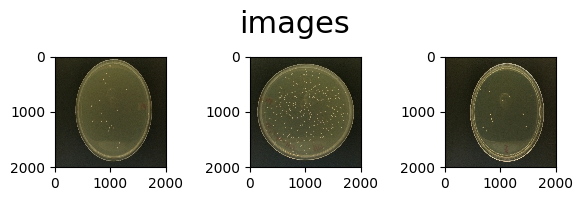

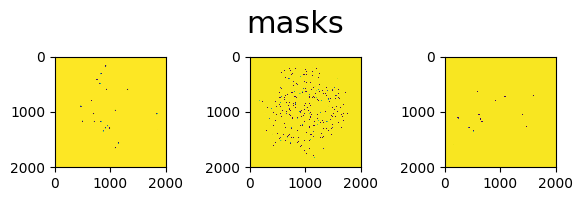

In [4]:
# Plot a batch.
inputs, outputs = images_masks.get_batch(3)
visualization.show_image_grid(inputs, 1, 3, 2, 6, "images")
visualization.show_image_grid(outputs, 1, 3, 2, 6, "masks")

In [ ]:
# Normalize the images.
#def normalize(batch):
#    inputs, outputs = batch
#    inputs = preprocess.smdm_normalize(inputs, 25, "REFLECT")
#    return (inputs, outputs)
#images_masks.map_batch(normalize)

In [ ]:
# Plot a batch.
#inputs, outputs = images_masks.get_batch(3)
#visualization.show_image_grid(inputs, 1, 3, 2, 6, "images")
#visualization.show_image_grid(outputs, 1, 3, 2, 6, "masks")

In [5]:
# Extract patches from the images.
def extract_patches(example):
    input_, output = example
    input_ = preprocess.extract_patches(input_, 25, 100000, 42114)
    output = preprocess.extract_patches(output, 25, 100000, 42114)
    examples = [(input_[i, ...] / 255, 0 if output[i, 25//2 + 1, 25//2 + 1] > 50 else 1) for i in range(input_.shape[0])]
    return examples
images_masks.map(extract_patches)

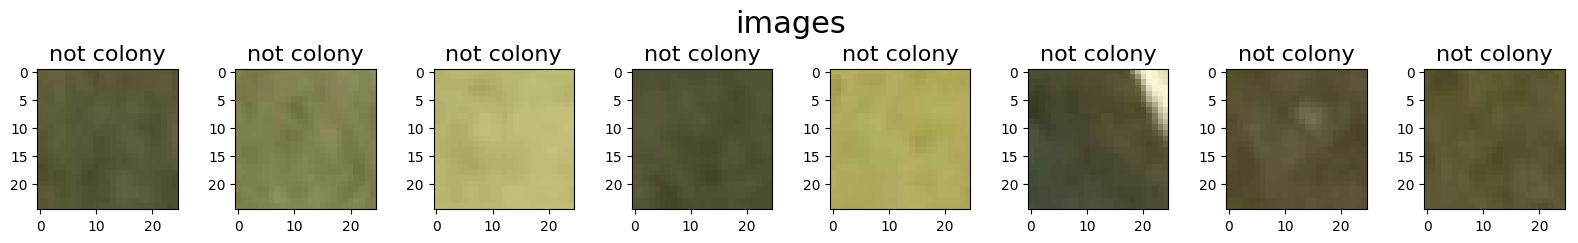

In [6]:
# Plot a batch.
inputs, outputs = images_masks.get_batch(8)
visualization.show_image_grid(inputs * 255, 1, 8, 2.5, 16, "images",
                              [("colony" if outputs[i] == 1 else "not colony") for i in range(outputs.shape[0])])

In [7]:
# Split the dataset.
train, test = images_masks.split(0.4)

In [69]:
# Create the net.
import tensorflow as tf
net = convnet1.ConvNet1("saves/17-11-27-PM-03-54", 120)

In [70]:
# Create some metrics.
train_data = train.get_batch(1000)
test_data = test.get_batch(1000)
loss_fn = losses.mse_loss
metrics = {
    "train_loss": metric.LossMetric(train_data, loss_fn),
    "test_loss": metric.LossMetric(test_data, loss_fn),
    "pred_thpt": metric.PredictionThroughputMetric(test_data)
}

In [71]:
# Make a function for plotting the metrics.
def plot_metrics():
    xs, ys = metrics["train_loss"].get_results()
    visualization.plot_line(xs, ys, "Training Loss", "training examples seen", "cross-entropy loss on training data",
                            3, 10)
    xs, ys = metrics["test_loss"].get_results()
    visualization.plot_line(xs, ys, "Test Loss", "training examples seen", "cross-entropy loss on test data", 3, 10)
    xs, ys = metrics["pred_thpt"].get_results()
    visualization.plot_line(xs, ys, "Training Throughput", "training examples seen", "speed of training in examples/s",
                            3, 10)

In [72]:
# Alternately train and evaluate the net for 30 minutes.
for _ in range(30//3):
    net.train(train, 3*60)
    net.evaluate(metrics)
    plot_metrics()

ERROR:tensorflow:Model diverged with loss = NaN.


NanLossDuringTrainingError: NaN loss during training.

In [ ]:
# Close the dataset.
microbia_segments.close()